<a href="https://colab.research.google.com/github/adilovungal/Credit-Card-Fraud-Analysis/blob/main/Credit_Card_Fraud_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection (Imbalanced Classification)

## Problem Statement
The goal is to build machine learning models to detect fraudulent credit card transactions in a highly imbalanced dataset. Because fraud cases are rare, evaluation focuses on recall, precision, F1-score, and ROC-AUC rather than accuracy.

## Dataset
- Highly imbalanced binary classification
- Fraud = 1
- Non-fraud = 0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

## Load data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Datasets/creditcard.csv')
# I uploaded the dataset in Google Drive so that it is easier to load to the Colab. The file size is 143 MB. Uploading it directly is a time consuming task.
print(df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Check Missing Values

In [7]:
print(df.isna().sum().sum(), "total missing values")

# Safety check for target
print("NaNs in target:", df['Class'].isna().sum())

# Drop if any exist (safe guard)
df = df.dropna(subset=['Class'])


0 total missing values
NaNs in target: 0


## Class Imbalance Check

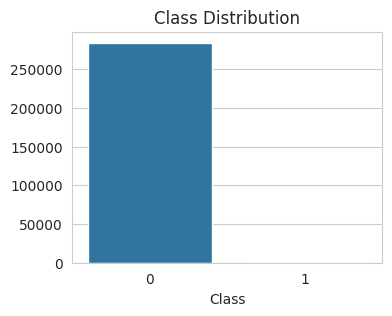

Class
0    0.998273
1    0.001727
Name: count, dtype: float64


In [8]:
fraud_counts = df['Class'].value_counts()

plt.figure(figsize=(4,3))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Class Distribution")
plt.show()

print(fraud_counts / len(df))


## Train-Test Split
Stratified split is used to preserve fraud ratio in both sets.


In [9]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (227845, 30)
Test shape: (56962, 30)


## Feature Scaling (Important for Logistic Regression)


In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model 1 — Logistic Regression
Class weights are used to handle severe class imbalance.


In [11]:
#Train LR
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Logistic Regression ROC-AUC: 0.9720834996210077


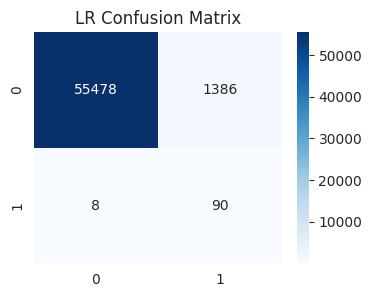

In [12]:
#Evaluate LR

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))

roc_lr = roc_auc_score(y_test, y_prob_lr)
print("Logistic Regression ROC-AUC:", roc_lr)

cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(4,3))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("LR Confusion Matrix")
plt.show()


## Model 2 — Random Forest


In [13]:
#Train RF
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)  # RF does NOT require scaling

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]



In [14]:
#Evaluate RF
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

roc_rf = roc_auc_score(y_test, y_prob_rf)
print("Random Forest ROC-AUC:", roc_rf)

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Random Forest ROC-AUC: 0.952908497036969


## ROC Curve Comparison


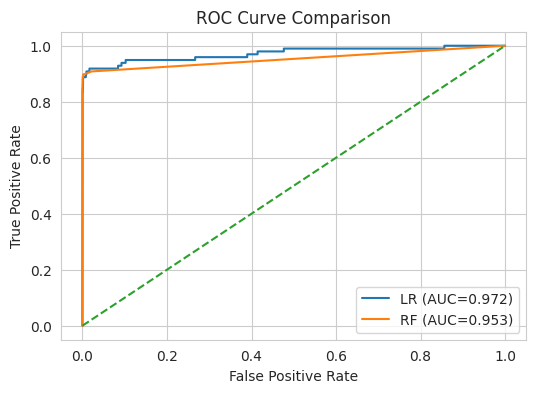

In [15]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()



## Precision–Recall Curve

Because fraud detection is highly imbalanced, the Precision–Recall curve provides a more informative view of model performance than ROC alone.


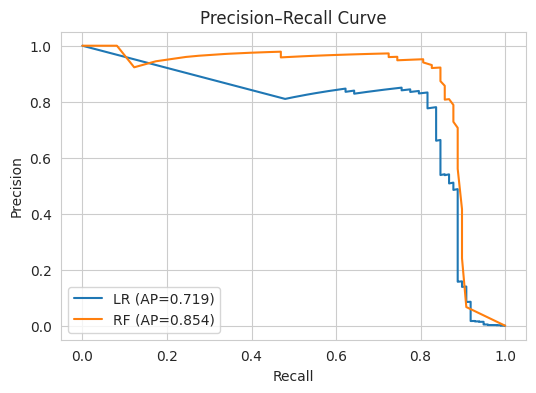

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Logistic Regression PR
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
ap_lr = average_precision_score(y_test, y_prob_lr)

# Random Forest PR
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
ap_rf = average_precision_score(y_test, y_prob_rf)

plt.figure(figsize=(6,4))
plt.plot(recall_lr, precision_lr, label=f"LR (AP={ap_lr:.3f})")
plt.plot(recall_rf, precision_rf, label=f"RF (AP={ap_rf:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


## Stratified Cross-Validation

To obtain more stable performance estimates on the imbalanced dataset, stratified cross-validation is performed.


In [17]:
print(y.value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
lr_cv_scores = cross_val_score(
    LogisticRegression(class_weight='balanced', max_iter=5000),
    X,
    y,
    cv=skf,
    scoring='roc_auc'
)

print("LR CV ROC-AUC mean:", lr_cv_scores.mean())
print("LR CV ROC-AUC std:", lr_cv_scores.std())


LR CV ROC-AUC mean: 0.9793147317776689
LR CV ROC-AUC std: 0.007891800012482075


In [19]:
rf_cv_scores = cross_val_score(
    RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    X,
    y,
    cv=skf,
    scoring='roc_auc'
)

print("RF CV ROC-AUC mean:", rf_cv_scores.mean())
print("RF CV ROC-AUC std:", rf_cv_scores.std())


RF CV ROC-AUC mean: 0.9508353457957897
RF CV ROC-AUC std: 0.00826316386617688


## Random Forest Feature Importance

Feature importance helps identify which variables contribute most to fraud detection.


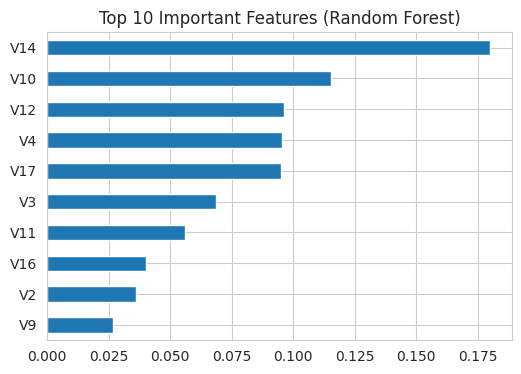

In [20]:
importances = rf.feature_importances_
feature_names = X.columns

feat_imp = pd.Series(importances, index=feature_names)
top_features = feat_imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(6,4))
top_features.plot(kind='barh')
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


## Conclusion

LR achieved higher ROC-AUC (0.972) suggesting strong linear separability in the PCA-transformed space. However RF is preferable for operational deployment due to 96% precision versus LR's 6%, significantly reducing false alarms at the cost of lower recall.